In [1]:
import sys

sys.path.append('..')

import sys

sys.path.append('..')
from relu_nets import ReLUNet
from hyperbox import Hyperbox
from helper_functions_demo import *
from lipMIP import LipMIP
from other_methods import StochasticApproximationUCBDynamic


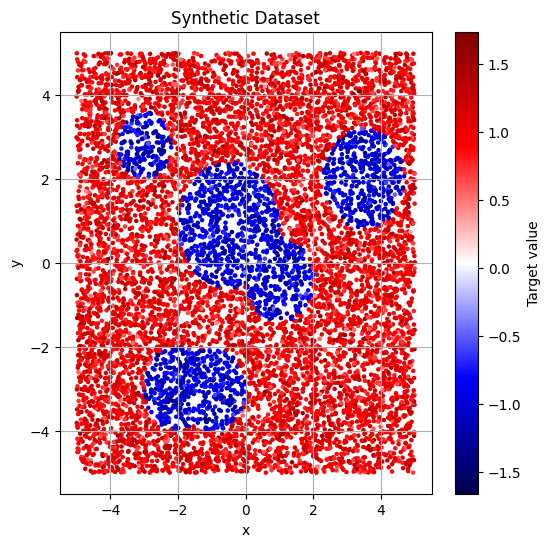

In [2]:
DIMENSION = 2
rad = 5.0
domain = Hyperbox.build_custom_hypercube(DIMENSION, 0, rad)
c_vector = torch.Tensor([1.0, -1.0])

num_points = 10000
X = np.random.uniform(-5, 5, size=(num_points, 2))
X = torch.Tensor(X)

lakes = [((-0.5, 0.9), 1.5), ((-2, -3), 1.0), ((-1, -3), 1), ((3.5, 2), 1.2), ((-3, 2.8), 0.8), ((1, -0.4), 1.0)]

def is_in_region(point):
    return any(np.linalg.norm(point - np.array(center)) < radius for center, radius in lakes)

y = np.array([-1.0 if is_in_region(p) else 1.0 for p in X])
y += np.random.normal(scale=0.2, size=y.shape)
y = torch.Tensor(y)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='seismic', s=5)
plt.colorbar(label="Target value")
plt.title("Synthetic Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [3]:
trained_network = ReLUNet([DIMENSION, 32, 32, 32, 32, 32, 1])
c_vector = torch.Tensor([1.0])

train_X = X[:int(num_points * 0.8)]
train_y = y[:int(num_points * 0.8)].unsqueeze(1)
test_X = X[int(num_points * 0.8):]
test_y = y[int(num_points * 0.8):].unsqueeze(1)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(trained_network.parameters(), lr=1e-3)

epochs = 300
for epoch in range(epochs):
    trained_network.train()
    pred = trained_network(train_X)
    loss = loss_fn(pred, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        trained_network.eval()
        pred = trained_network(test_X)
        loss = loss_fn(pred, test_y)
        print(f"Epoch {epoch}: Loss: {loss.item():.4f}")

Epoch 0: Loss: 0.9942
Epoch 50: Loss: 0.6095
Epoch 100: Loss: 0.5175
Epoch 150: Loss: 0.4156
Epoch 200: Loss: 0.2965
Epoch 250: Loss: 0.1714


maximum = 11.904756546020508 on (-0.03333333333335098 -3.5666666666666718)


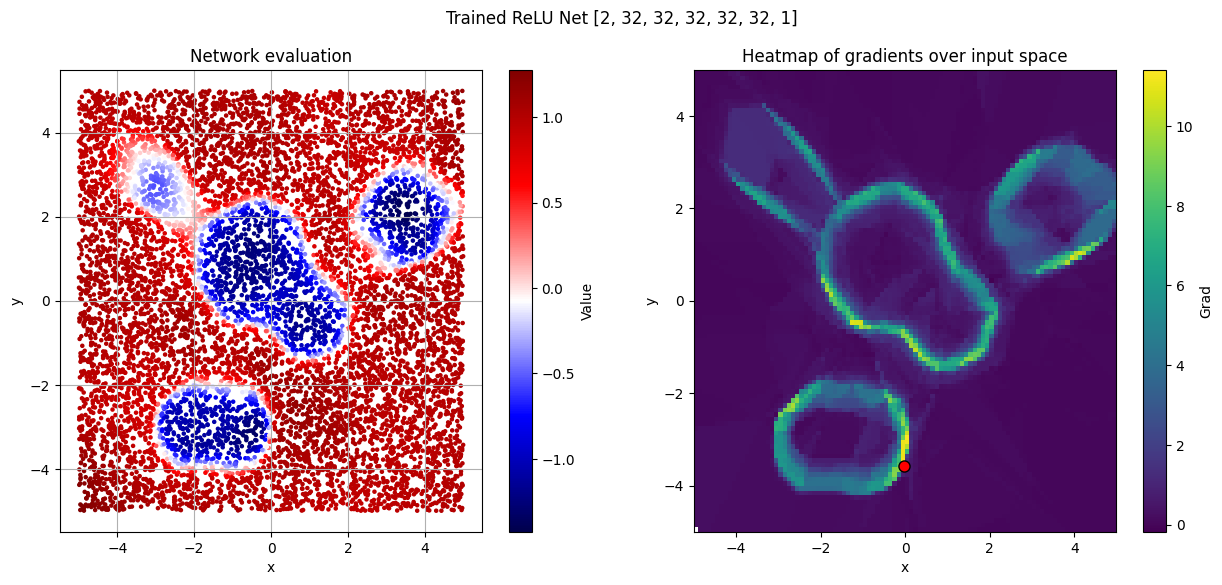

maximum = 11.904756546020508 on (-0.03333333333335098 -3.5666666666666718)
maximum = 11.904756546020508 on (-0.03333333333335098 -3.5666666666666718)


In [4]:
plot_value_and_grads(net=trained_network, domain=domain, radius=rad, dimension=DIMENSION, is_trained=True, px=300)
XS_trained, GS_trained, maximum_trained, maximum_x_trained, maximum_y_trained = get_xs_gs_maximum(net=trained_network, radius=rad, dimension=DIMENSION, px=300)
pt = domain.random_point(100000)
vals_trained = trained_network(pt).detach().numpy()

In [5]:
lipMip = LipMIP(trained_network, domain, c_vector, verbose=False, num_threads=11)
lm_result = lipMip.compute_max_lipschitz()
lm_result.as_dict()['value']

12.615529062394167

In [6]:
SA = StochasticApproximationUCBDynamic(trained_network, c_vector, domain, c=15, partition_step=2, use_c_vector=True)
result = SA.compute(max_iter=100000, v=False, exact=lm_result.as_dict()["value"], tol=5, mode="Relative")
result, SA.iteration_count

(tensor([12.0194]), 11410)

In [7]:
torch.abs(lm_result.as_dict()['value'] - result) / result * 100.0

tensor([4.9594])

In [ ]:
res = {}

In [32]:
c_list = [0.001 * (10**i) for i in range(10)]
c_list

[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

In [33]:
for c in c_list:
    if c > 10000:
        res[c] = np.zeros(10)
        for k in range(10):
            SA = StochasticApproximationUCBDynamic(trained_network, c_vector, domain, c=c, partition_step=2, use_c_vector=True)
            result = SA.compute(max_iter=100000, v=False, exact=lm_result.as_dict()["value"], tol=5, mode="Relative")
            res[c][k] = SA.iteration_count
    print(f"{c}: {res[c]}")

0.001: [100000.    619. 100000. 100000. 100000. 100000. 100000.    216.    655.
 100000.]
0.01: [100000.    287. 100000. 100000.   1116. 100000. 100000. 100000. 100000.
   1694.]
0.1: [   838. 100000. 100000. 100000. 100000. 100000. 100000. 100000.    817.
 100000.]
1.0: [100000. 100000. 100000. 100000. 100000. 100000. 100000. 100000.   9055.
 100000.]
10.0: [100000. 100000.   1440. 100000.  17007.   5251.   7652.   8509.    163.
  34434.]
100.0: [77599. 28523.  9939.  3523. 38312. 11488.  4244. 53749. 17265.  8859.]
1000.0: [5.7000e+02 1.1890e+03 3.5000e+01 1.0000e+05 4.1090e+03 1.3955e+04
 1.9581e+04 2.2500e+03 4.4400e+03 1.8702e+04]
10000.0: [ 20730.  12244.  10015.   4013.   1680.   6220. 100000.   3393.  39122.
   9187.]
100000.0: [100000.  35378.  81773.   2046.   2299. 100000.  13957.   8196.   6528.
   1130.]
1000000.0: [100000.  43970.   1564.   5007.  17806.   4781.  17012.  34009. 100000.
   9312.]


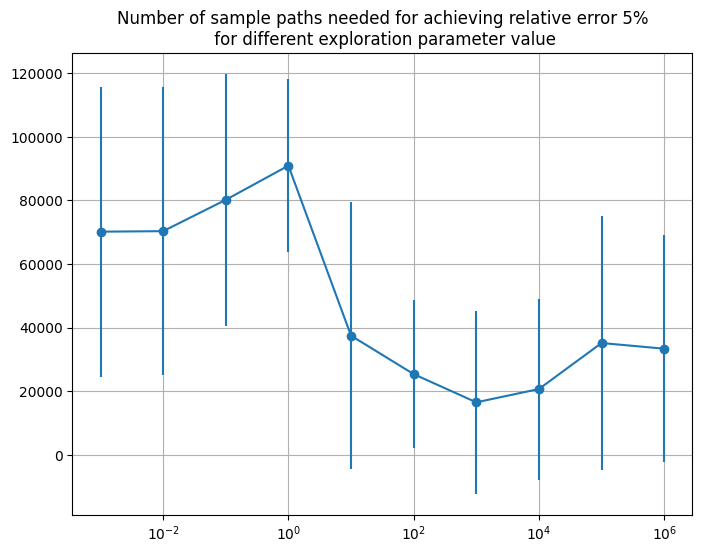

In [40]:
plt.figure(figsize=(8, 6))
plt.errorbar(c_list, [res[c].mean() for c in c_list], yerr=[res[c].std() for c in c_list], fmt='o-')
plt.xscale('log')
plt.grid(True)
plt.title("Number of sample paths needed for achieving relative error 5%\n for different exploration parameter value")
plt.show()

In [41]:
res_linear = {}

In [42]:
c_list_linear = [990 + (2*i) for i in range(10)]
c_list_linear

[990, 992, 994, 996, 998, 1000, 1002, 1004, 1006, 1008]

In [43]:
for c in c_list_linear:
    res_linear[c] = np.zeros(10)
    for k in range(10):
        SA = StochasticApproximationUCBDynamic(trained_network, c_vector, domain, c=c, partition_step=2, use_c_vector=True)
        result = SA.compute(max_iter=100000, v=False, exact=lm_result.as_dict()["value"], tol=5, mode="Relative")
        res_linear[c][k] = SA.iteration_count
    print(f"{c}: {res_linear[c]}")

990: [ 88990.   3656.  61193.  56204.  13648.   8131.  10351.  37754.   1494.
 100000.]
992: [ 48489.  17744.   2731. 100000. 100000.  62132.  23620.    258. 100000.
  15343.]
994: [ 1034. 21119. 80002.  2065.  8575.  3443. 10735. 31511.   147. 34710.]
996: [54876. 18178. 54528. 89426.  4245.  1229. 33238.  6943.  4094.  8020.]
998: [  9200.   1827.  16116. 100000.  36987.   1863.   3577.   9407.   1122.
   1702.]
1000: [ 18890. 100000.  81361.  35514.    566.   5361.  75576.  12903.  11670.
   9512.]
1002: [13614. 10288.  1159. 14112.  3201. 45027. 58624.  6083.  4532.  3839.]
1004: [34716. 18497.  9215. 47046. 70454. 44585. 10016. 60139.  2451.  4460.]
1006: [100000.    432.   1648.  10174.  35929.   3466.  26534.  16615.   1765.
   5012.]
1008: [22871.  2872.  8848. 10340.  3743. 16908. 34771. 45539. 11994.  5138.]


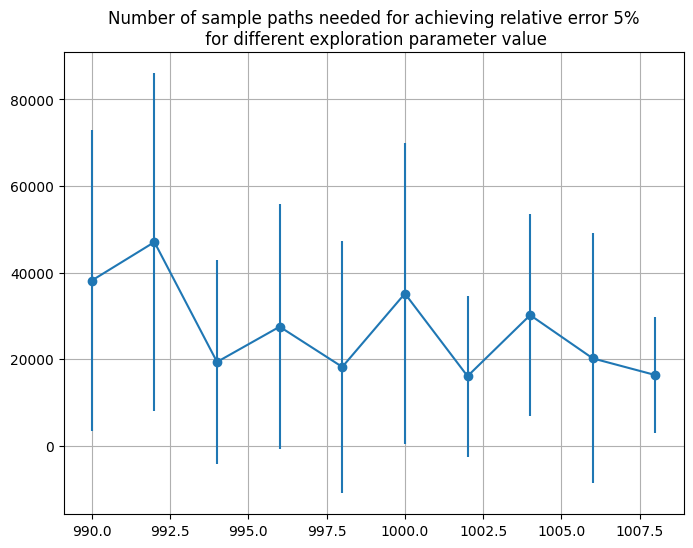

In [47]:
plt.figure(figsize=(8, 6))
plt.errorbar(c_list_linear, [res_linear[c].mean() for c in c_list_linear], yerr=[res_linear[c].std() for c in c_list_linear], fmt='o-')
plt.grid(True)
plt.title("Number of sample paths needed for achieving relative error 5%\n for different exploration parameter value")
plt.show()